In [1]:
!pip install -q -U keras-tuner


In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import random

# -----------------------------------
import tensorflow as tf
import keras
from tensorflow import keras
import keras_tuner as kt

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
train_images  = train_images / 255.0
test_images = test_images / 255.0

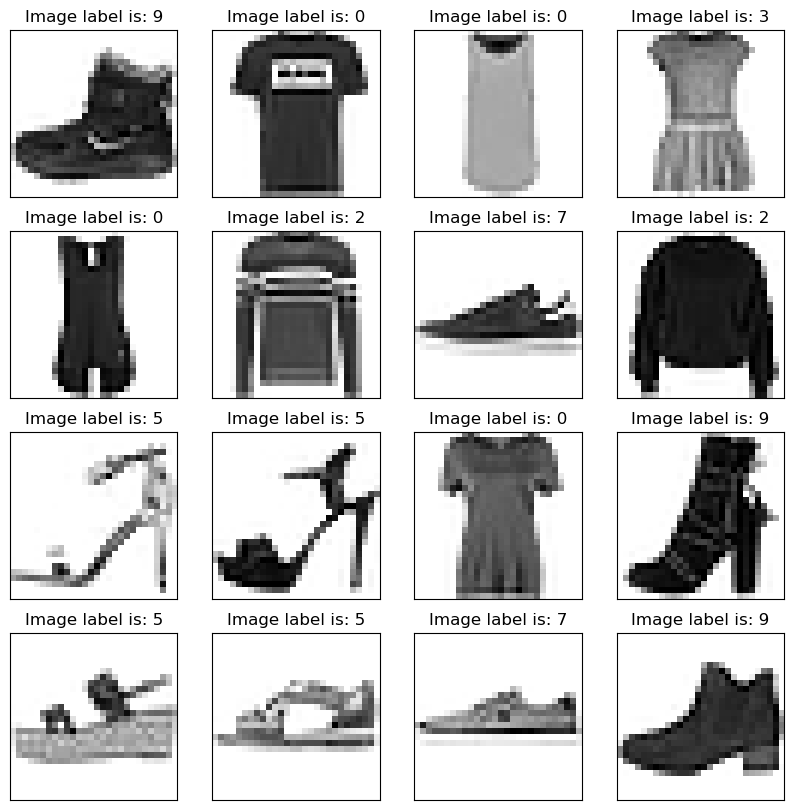

In [5]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.title("Image label is: {}".format(train_labels[i]))
plt.show()

In [6]:
x_train = train_images.reshape(-1,28,28,1)
x_test = test_images.reshape(-1,28,28,1)

In [7]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


In [8]:
def build_model(hp):
    model = keras.Sequential([
        
    # First conv_block
    keras.layers.Conv2D(
        filters = hp.Choice('conv_1_filter', values=[16, 32, 64, 128]),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,4]),
        activation='relu',
        input_shape=(28,28,1)),
    keras.layers.MaxPooling2D((2,2)),
    
    # Second conv_block
    keras.layers.Conv2D(
        filters = hp.Choice('conv_2_filter', values=[16, 32, 64, 128]),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,4]),
        activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    
    # --------------------------------
    keras.layers.Flatten(),
    keras.layers.Dense(units = hp.Choice('units', values=[16, 32, 64, 128, 256]),
                       activation='relu'),
    keras.layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)),
        
    # --------------------------------
    keras.layers.Dense(10)
    ])

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', 
                                                            values=[1e-1, 1e-2, 1e-3, 1e-4])),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

In [9]:
tuner = kt.Hyperband(build_model,
                     objective="val_accuracy",
                     max_epochs=5,
                     factor=3,
                     hyperband_iterations=3)

In [10]:
tuner.search_space_summary()


Search space summary
Default search space size: 7
conv_1_filter (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 4], 'ordered': True}
conv_2_filter (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 4], 'ordered': True}
units (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256], 'ordered': True}
dropout (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [11]:
tuner.search(x_train,train_labels, epochs=3, validation_split=0.2)


Trial 30 Complete [00h 01m 20s]
val_accuracy: 0.8388333320617676

Best val_accuracy So Far: 0.9036666750907898
Total elapsed time: 00h 34m 35s


In [12]:
best_hps = best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""conv_1_filter is {best_hps.get('conv_1_filter')}""")
print(f"""conv_1_kernel is {best_hps.get('conv_1_kernel')}""")
print(f"""conv_2_filter is {best_hps.get('conv_2_filter')}""")
print(f"""conv_2_kernel is {best_hps.get('conv_2_kernel')}""")
print("-------------------------------------------------")
print(f"""units is {best_hps.get('units')}""")
print(f"""learning_rate is {best_hps.get('learning_rate')}""")
print(f"""dropout is {best_hps.get('dropout')}""")

conv_1_filter is 16
conv_1_kernel is 4
conv_2_filter is 64
conv_2_kernel is 3
-------------------------------------------------
units is 64
learning_rate is 0.001
dropout is 0.0


In [13]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, train_labels, 
                    epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
1500/1500 [==============================] - 14s 9ms/step - loss: 0.5032 - accuracy: 0.8196 - val_loss: 0.4047 - val_accuracy: 0.8487
Epoch 2/50
1500/1500 [==============================] - 15s 10ms/step - loss: 0.3394 - accuracy: 0.8788 - val_loss: 0.3310 - val_accuracy: 0.8808
Epoch 3/50
1500/1500 [==============================] - 18s 12ms/step - loss: 0.2953 - accuracy: 0.8939 - val_loss: 0.2972 - val_accuracy: 0.8927
Epoch 4/50
1500/1500 [==============================] - 19s 13ms/step - loss: 0.2630 - accuracy: 0.9038 - val_loss: 0.2764 - val_accuracy: 0.8997
Epoch 5/50
1500/1500 [==============================] - 15s 10ms/step - loss: 0.2386 - accuracy: 0.9121 - val_loss: 0.2866 - val_accuracy: 0.8935
Epoch 6/50
1500/1500 [==============================] - 16s 10ms/step - loss: 0.2168 - accuracy: 0.9209 - val_loss: 0.2602 - val_accuracy: 0.9053
Epoch 7/50
1500/1500 [==============================] - 19s 12ms/step - loss: 0.1990 - accuracy: 0.9253 - val_loss: 0.2493 - 

In [14]:
hypermodel = tuner.hypermodel.build(best_hps)

history = hypermodel.fit(x_train, train_labels, 
                         epochs=best_epoch, 
                         validation_split=0.2, 
                         callbacks=[early_stop])

Epoch 1/16
1500/1500 [==============================] - 24s 15ms/step - loss: 0.4992 - accuracy: 0.8203 - val_loss: 0.3741 - val_accuracy: 0.8676
Epoch 2/16
1500/1500 [==============================] - 22s 15ms/step - loss: 0.3361 - accuracy: 0.8781 - val_loss: 0.3289 - val_accuracy: 0.8814
Epoch 3/16
1500/1500 [==============================] - 22s 15ms/step - loss: 0.2865 - accuracy: 0.8957 - val_loss: 0.2989 - val_accuracy: 0.8907
Epoch 4/16
1500/1500 [==============================] - 22s 15ms/step - loss: 0.2581 - accuracy: 0.9058 - val_loss: 0.2828 - val_accuracy: 0.8953
Epoch 5/16
1500/1500 [==============================] - 22s 15ms/step - loss: 0.2321 - accuracy: 0.9141 - val_loss: 0.2861 - val_accuracy: 0.8963
Epoch 6/16
1500/1500 [==============================] - 22s 15ms/step - loss: 0.2123 - accuracy: 0.9210 - val_loss: 0.2545 - val_accuracy: 0.9068
Epoch 7/16
1500/1500 [==============================] - 22s 15ms/step - loss: 0.1947 - accuracy: 0.9280 - val_loss: 0.2454 -

In [15]:
hypermodel.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 25, 25, 16)        272       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 12, 12, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 64)        9280      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                                 
 dense_4 (Dense)             (None, 64)               

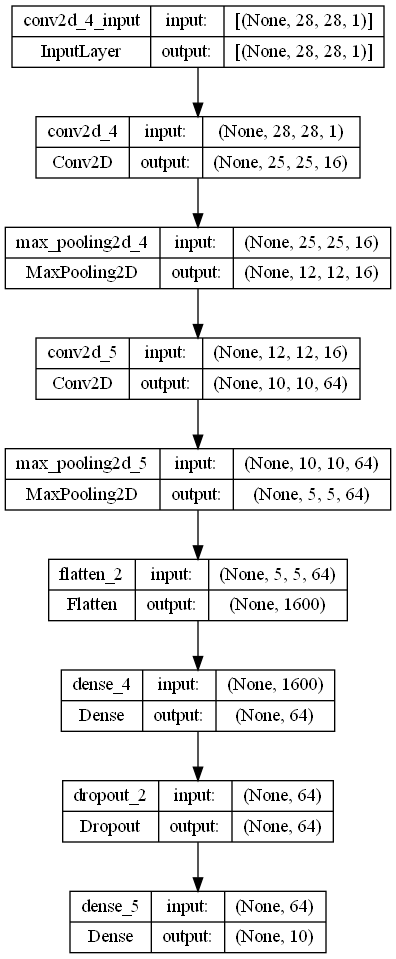

In [16]:
keras.utils.plot_model(hypermodel, show_shapes=True)


1/1 [==============================] - 0s 236ms/step


C:\Users\himan\AppData\Local\Temp\ipykernel_9528\3798688122.py:20: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
C:\Users\himan\AppData\Local\Temp\ipykernel_9528\3798688122.py:23: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


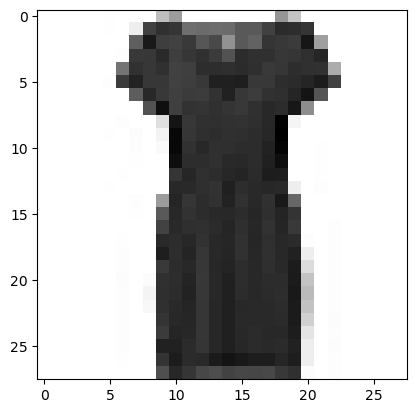

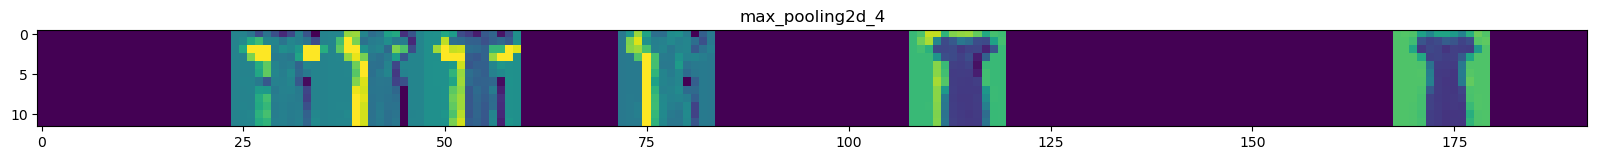

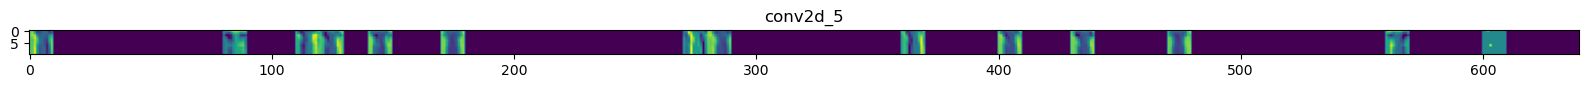

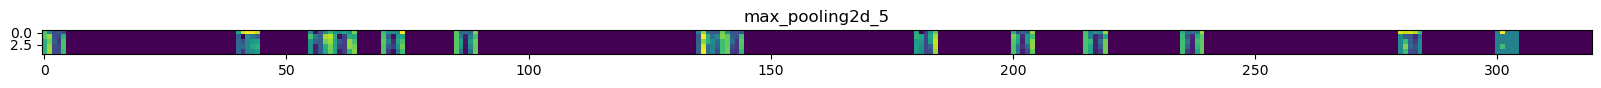

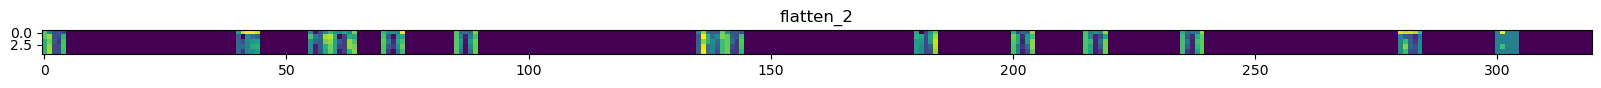

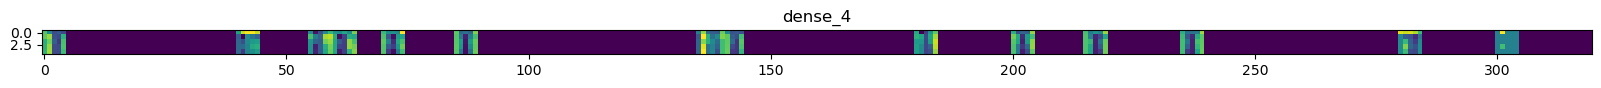

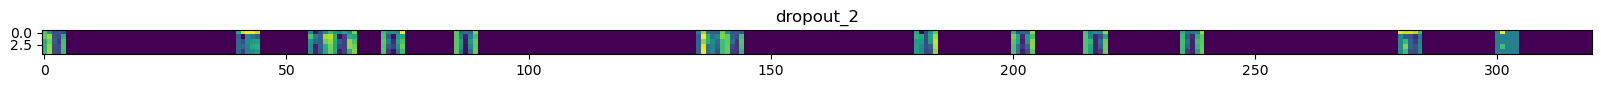

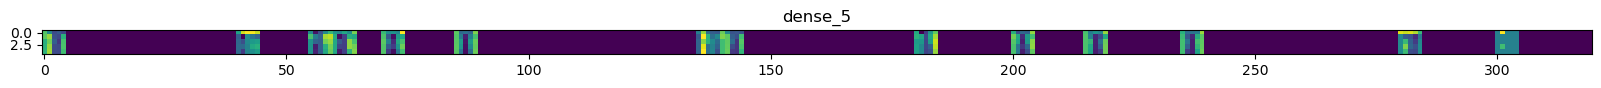

In [17]:
successive_outputs = [layer.output for layer in hypermodel.layers[1:]]
visualization_model = keras.models.Model(inputs = hypermodel.input, outputs = successive_outputs)
index = 20
plt.imshow(train_images[index], cmap=plt.cm.binary)

x = train_images[index]
x = x.reshape((1,) + x.shape)
x /= 255
successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in hypermodel.layers[1:]]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1] 
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x

    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [18]:
eval_result = hypermodel.evaluate(x_test, test_labels)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 2s 4ms/step - loss: 0.2795 - accuracy: 0.9062
[test loss, test accuracy]: [0.2794649004936218, 0.9061999917030334]


In [19]:
pred = hypermodel.predict(x_test)

print("Prediction is -> {}".format(pred[12]))
print("Actual value is -> {}".format(test_labels[12]))
print("The highest value for label is {}".format(np.argmax(pred[12])))


313/313 [==============================] - 2s 5ms/step
Prediction is -> [ -7.325134    -5.703616   -10.929257    -5.6341953  -15.396121
   8.474077    -9.750004     5.331627    -2.1736984    0.10583208]
Actual value is -> 7
The highest value for label is 5


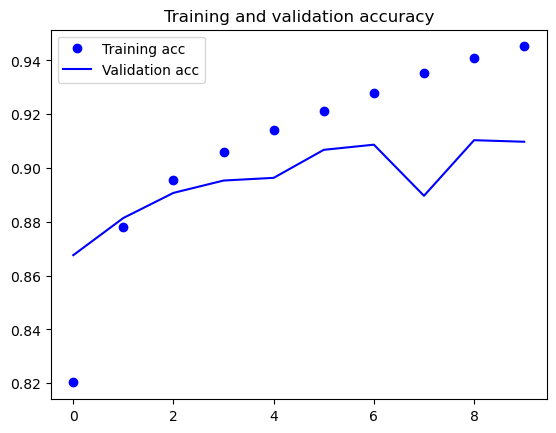

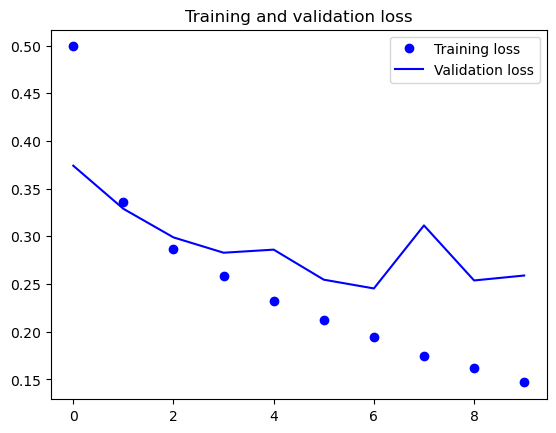

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss'] 

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()